In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
import cv2
import shutil
import glob
import os
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50


In [189]:
!rm -r ~/.kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [190]:
! pip install kaggle
! kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection

brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [191]:
! unzip /content/brain-mri-images-for-brain-tumor-detection.zip -d /content

Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
replace /content/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/brain_tumor_dataset/no/17 no.jpg  
  inflating: /content/brain_tumor_dataset/no/18 no.jpg  
  inflating: /content/brain_tumor_dataset/no/19 no.jpg  
  inflating: /content/brain_tumor_dataset/no/2 no.jpeg  
  inflating: /content/brain_tumor_dataset/no/20 no.jpg  
  inflating: /content/brain_tumor_dataset/no/21 no.jpg  
  inflating: /content/brain_tumor_dataset/no/22 no.jpg  
  inflating: /content/brain_tumor_dataset/no/

In [192]:
!rm -r /content/no
!rm -r /content/yes

In [193]:
data = "/content/brain_tumor_dataset"
No_brain_tumor = "/content/brain_tumor_dataset/no"
Yes_brain_tumor = "/content/brain_tumor_dataset/yes"

In [194]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [195]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/brain_tumor_dataset/no/N22.JPG,No
1,/content/brain_tumor_dataset/no/no 8.jpg,No
2,/content/brain_tumor_dataset/no/44no.jpg,No
3,/content/brain_tumor_dataset/no/no 99.jpg,No
4,/content/brain_tumor_dataset/no/no 9.png,No


In [196]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


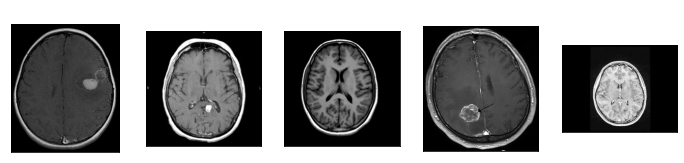

In [197]:
plt.figure(figsize=(12,8))
for i in range(5):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [198]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [199]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [200]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)


Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [201]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [202]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3), include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_12  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_68 (Dense)            (None, 128)               196736    
                                                                 
 batch_normalization_6118 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                     

In [203]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.6574
Epoch 00001: val_loss improved from inf to 1.02759, saving model to Tumor_classifier_model.h5
14/14 [==============================] - 40s 1s/step - loss: 0.7123 - accuracy: 0.6574 - val_loss: 1.0276 - val_accuracy: 0.5417
Epoch 2/40
14/14 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.7917
Epoch 00002: val_loss improved from 1.02759 to 0.65577, saving model to Tumor_classifier_model.h5
14/14 [==============================] - 10s 714ms/step - loss: 0.4620 - accuracy: 0.7917 - val_loss: 0.6558 - val_accuracy: 0.7500
Epoch 3/40
14/14 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8611
Epoch 00003: val_loss improved from 0.65577 to 0.58920, saving model to Tumor_classifier_model.h5
14/14 [==============================] - 10s 717ms/step - loss: 0.3924 - accuracy: 0.8611 - val_loss: 0.5892 - val_accuracy: 0.7500
Epoch 4/40
14/14 [=================

In [204]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 0s 221ms/step - loss: 0.1728 - accuracy: 1.0000


[0.1728484332561493, 1.0]

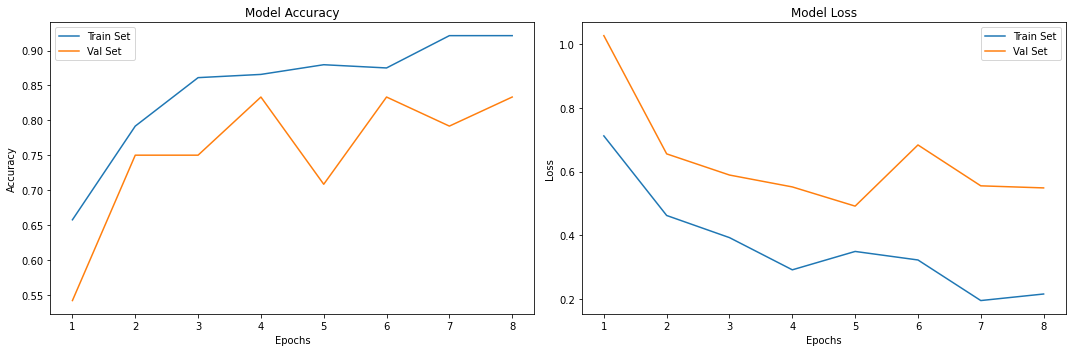

In [205]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()